In [2]:
from numpy import *
from pathlib import Path

In [3]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t')) - 1
    dataMat = []
    labelMat = []
    fr = open(fileName)
    
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [4]:
def standRegress(xArr,yArr):
    xMat = mat(xArr)
    yMat = mat(yArr).T
    xTx = xMat.T * xMat
    
    if linalg.det(xTx) == 0.0:
        print('This matrix is singular, cannot do inverse')
        return
    ws = xTx.I * (xMat.T * yMat)
    return ws

In [6]:
data_path = Path('D:\python_algorithm\machinelearinginaction\《机器学习实战》Python3代码\Ch08')

In [7]:
xArr,yArr = loadDataSet(data_path / 'ex0.txt')

In [10]:
ws = standRegress(xArr,yArr)

In [11]:
ws

matrix([[3.00774324],
        [1.69532264]])

In [12]:
xCopy = mat(xArr).copy()

In [28]:
xMat = mat(xArr)
yMat = mat(yArr)
yHat = xMat * ws

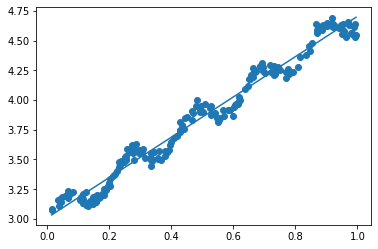

In [43]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0],yMat.T[:,0].flatten().A[0])
xCopy = xMat.copy()
xCopy.sort(0)
yHat = xCopy * ws
ax.plot(xCopy[:,1],yHat)

In [44]:
#相关系数
corrcoef(yHat.T,yMat)

array([[1.        , 0.13653777],
       [0.13653777, 1.        ]])

In [45]:
#8.2 局部加权线性回归

In [49]:
def lwlr(testPoint,xArr,yArr,k=1.0):
    xMat = mat(xArr)
    yMat = mat(yArr).T
    
    m = shape(xMat)[0]
    weights = mat(eye(m))    #对角矩阵
    
    for j in range(m):       #计算以高斯核为权重类型的权重
        diffMat = testPoint - xMat[j,:]
        weights[j,j] = exp(diffMat*diffMat.T/(-2.0*k**2))
    
    xTx = xMat.T * (weights * xMat)
    if linalg.det(xTx) == 0.0:
        print('this matrix is singular,cannot do inverse')
        return
    ws = xTx.I * (xMat.T * (weights * yMat))                #求测试点附近回归系数
    return testPoint * ws

def lwlrTest(testArr, xArr, yArr, k=1.0):
    m = shape(testArr)[0]
    yHat = zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i],xArr,yArr,k)
        
    return yHat

In [50]:
yArr[0]

3.176513

In [51]:
lwlr(xArr[0],xArr,yArr,1.0)

matrix([[3.12204471]])

In [52]:
yHat = lwlrTest(xArr,xArr,yArr,0.003)

In [53]:
#绘图

In [54]:
xMat = mat(xArr)
srtInd = xMat[:,1].argsort(0)
xSort = xMat[srtInd][:,0,:]

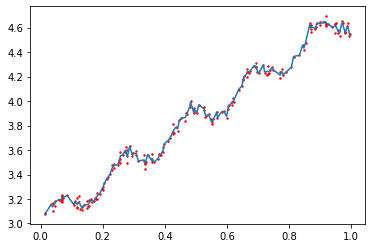

In [61]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xSort[:,1],yHat[srtInd])
ax.scatter(xMat[:,1].flatten().A[0], mat(yArr).T.flatten().A[0], s=2,c='red')
plt.show()

In [63]:
#岭回归。数据的特征比样本点多的问题。
#取名岭，是因为引入了单位矩阵（单位矩阵的对角线全为1，组成了“岭”）

In [67]:
def ridgeRegress(xMat,yMat,lam=0.2):
    xTx = xMat.T * xMat
    denom = xTx + eye(shape(xMat)[1]) * lam
    
    if linalg.det(denom) == 0.0:
        print('this matrix is singular, cannot do inverse')
        return
    
    ws = denom.I * (xMat.T * yMat)
    return ws

def ridgeTest(xArr, yArr):
    xMat = mat(xArr)
    yMat = mat(yArr).T
    
    yMean = mean(yMat,0)
    yMat = yMat - yMean         #特征标准化处理
    xMeans = mean(xMat,0)
    xVar = var(xMat,0)
    xMat = (xMat - xMeans)/xVar
    
    numTestPts = 30
    wMat = zeros((numTestPts,shape(xMat)[1]))
    for i in range(numTestPts):
        ws = ridgeRegress(xMat,yMat,exp(i-10))
        wMat[i,:] = ws.T
    return wMat
    

In [68]:
xArr,yArr = loadDataSet(data_path / 'abalone.txt')

In [69]:
ridgeWeights = ridgeTest(xArr,yArr)

In [73]:
ridgeWeights[0]

array([ 0.04304419, -0.02274163,  0.13214088,  0.02075182,  2.22403745,
       -0.99895298, -0.11725424,  0.16622922])

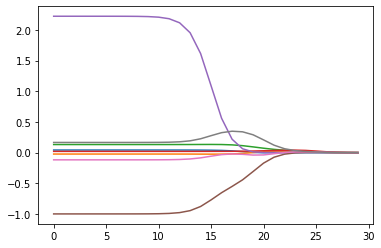

In [78]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ridgeWeights)    #每一列绘制一个曲线
plt.show()

In [79]:
#逐步前向回归。属于贪心算法，每一步都尽可能减少误差。

In [88]:
def rssError(yArr,yHatArr):
    return ((yArr-yHatArr)**2).sum()

def stageWise(xArr,yArr,eps = 0.01, numIt = 100):
    xMat = mat(xArr)
    yMat = mat(yArr).T
    
    yMean = mean(yMat,0)
    yMat = yMat - yMean
    
    xMeans = mean(xMat,0)
    xVar = var(xMat,0)
    xMat = (xMat - xMeans)/xVar
    
    m,n = shape(xMat)
    
    returnMat = zeros((numIt,n))
    ws = zeros((n,1))
    wsTest = ws.copy()
    wsMax = ws.copy()
    
    for i in range(numIt):
        #print(ws.T)
        lowestError = float(inf)
        for j in range(n):
            for sign in [-1,1]:
                wsTest = ws.copy()
                wsTest[j] += eps*sign
                yTest = xMat * wsTest
                
                rssE = rssError(yMat.A,yTest.A)
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()
        returnMat[i,:] = ws.T
    return returnMat

In [89]:
stageWise(xArr,yArr,0.01,200)

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.04,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36]])

In [90]:
stageWise(xArr,yArr,0.001,5000)

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.044, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187]])